# SP22: Machine Learning for Signal Processing - Assignment 6


## Name : Akhila Sakiramolla (asakiram@iu.edu)
## UID : 2000886005

## Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
from PIL import Image
import IPython
import random
import librosa as lb
import IPython.display as ipd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import scipy.io
# To execute a cell line by line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# P1: Stereo Matching (revisited) 

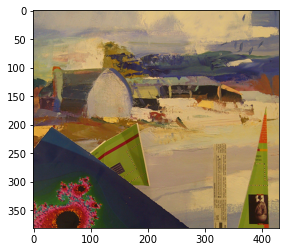

In [3]:
Xl = mpimg.imread("im0.ppm")
imgplot = plt.imshow(Xl)

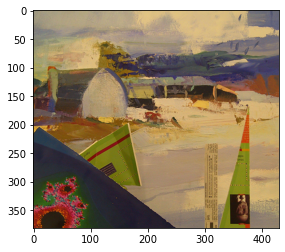

In [4]:
Xr = np.array(Image.open("im8.ppm"))
imgplot = plt.imshow(Xr)

In [4]:
# Initializing disparity map
D = np.zeros((381, 390))

# Creating a disparity map whose (i, j)-th element says the index-distance between the (i, j)-th pixel of the right image and its closest pixel in the left image
for i in range(len(Xr)):
  for j in range(len(Xr[0])-40):
    Xr_val = Xr[i][j]
    dist = 0
    min_dist = 99999   

    for k in range(40):
      Xl_val = Xl[i][j+k]
      dist = np.sqrt(np.sum((Xr_val - Xl_val)**2))
      if dist < min_dist:
        min_dist = dist
        D[i][j] = k

print("Shape of Disparity matrix (D) : ", D.shape)
print("Disparity matrix (D) : ", D)

Shape of Disparity matrix (D) :  (381, 390)
Disparity matrix (D) :  [[ 2.  7. 14. ...  1. 12.  7.]
 [ 9. 10.  3. ... 25.  5. 10.]
 [ 3.  5.  7. ... 30. 29. 10.]
 ...
 [16. 27. 13. ... 37. 39. 23.]
 [34. 31.  3. ... 33. 31. 33.]
 [26. 36. 35. ... 27. 32.  4.]]


Vectorized Disparity matrix (D1) :  [ 2.  7. 14. ... 27. 32.  4.]


(array([ 3643.,  3657.,  3850.,  3985.,  4257.,  4779.,  5759.,  9012.,
        11829.,  8165.,  6005.,  4755.,  4196.,  3897.,  3819.,  4149.,
         3560.,  3102.,  2903.,  2979.,  2889.,  2925.,  3097.,  3219.,
         3196.,  3115.,  2740.,  2575.,  2433.,  2453.,  2412.,  2543.,
         2621.,  2454.,  2140.,  2059.,  1973.,  1768.,  1827.,  1850.]),
 array([ 0.   ,  0.975,  1.95 ,  2.925,  3.9  ,  4.875,  5.85 ,  6.825,
         7.8  ,  8.775,  9.75 , 10.725, 11.7  , 12.675, 13.65 , 14.625,
        15.6  , 16.575, 17.55 , 18.525, 19.5  , 20.475, 21.45 , 22.425,
        23.4  , 24.375, 25.35 , 26.325, 27.3  , 28.275, 29.25 , 30.225,
        31.2  , 32.175, 33.15 , 34.125, 35.1  , 36.075, 37.05 , 38.025,
        39.   ]),
 <a list of 40 Patch objects>)

Text(0.5, 1.0, 'Vectorized Disparity matrix')

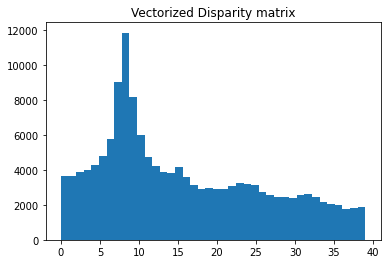

In [5]:
# Vectorizing the diparity matrix
D1 = D.flatten()
print("Vectorized Disparity matrix (D1) : ", D1)

# Plotting the histogram of the Vectorized Disparity matrix 
plt.hist(D1, bins = 40)
plt.title('Vectorized Disparity matrix')
plt.show()

From the above histogram, I observe that there are 4 clusters.

## Expectation Maximiztion algorithm

The expectation–maximization (EM) algorithm is an iterative approach for determining (local) maximum likelihood or maximum a posteriori (MAP) parameter estimates in statistical models that rely on unobserved latent variables. The EM iteration alternates between an expectation (E) step that constructs a function for the expected log-likelihood evaluated using the current estimate for the parameters and a maximization (M) phase that computes parameters that maximize the expected log-likelihood discovered on the E step. In the next E phase, these parameter estimates are utilized to determine the distribution of the latent variables.

(Reusing code from previous assignment) 

In [6]:
# Function to Initiliaze the mean, variance and prior

def initializeData(df,k):
  mean_mat = np.array([random.uniform(min(D1),max(D1)) for _ in range(4)], dtype = float).reshape(1,-1)
  var_mat = np.array([random.uniform(0,2) for _ in range(4)], dtype = float).reshape(1,-1)
  prior_prob = 1/k
  prior_prob_mat = (np.array([prior_prob]*k)).reshape(1, -1)
    
  return mean_mat, var_mat, prior_prob_mat

E - step : calculate posterior probabilities


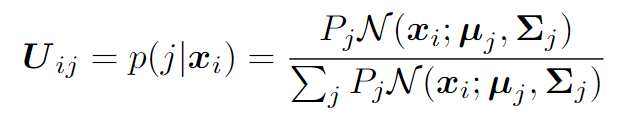

In [7]:
# Function to compute Gaussian pdf

def gaussianPDF(x,mu,var):
    return ((1/(2*np.pi*var)**0.5)*np.exp(-1/2*((x-mu)**2)*(1/var)))

In [8]:
# Function to calculate posterior probability - E step

def expectation(df,k,mean,var,prior_prob_mat):
  n = D1.shape[0]
  pdf = np.ones((n,k))
  total_wts = np.ones((n,k))
  post_prob = np.ones((n,k))

  for i in range(k):
    pdf[:,i] = gaussianPDF(D1, mean[:,i], var[:,i])

  total_wts = pdf*prior_prob_mat

  post_prob = total_wts/(np.dot(total_wts, prior_prob_mat.T))

  return post_prob

M - step : to update mean, variance and prior parameteres

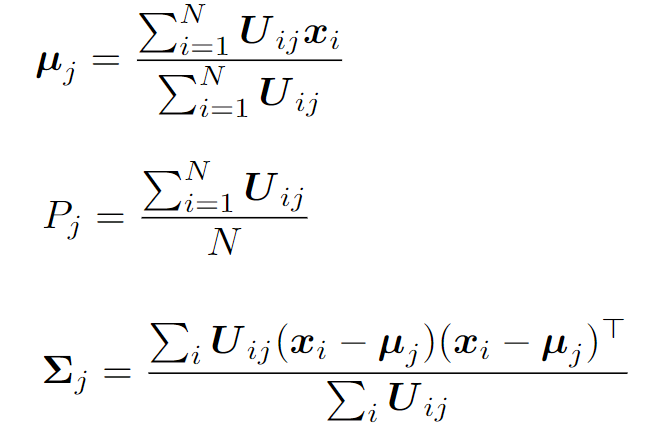

In [9]:
# Function to re-estimate the mean, variance and prior - M step

def maximization(k, post_prob, df):
  var_updated = np.ones((1,4))

  mean_updated = np.divide(np.sum(post_prob*D1.reshape(-1,1), axis = 0), np.sum(post_prob,axis=0))
  mean_updated = mean_updated.reshape(1,-1)

  prior_updated = np.divide(np.sum(post_prob, axis = 0), post_prob.shape[0])
  prior_updated = prior_updated.reshape(1, -1)

  for i in range(k):
    var_updated[:,i] = np.sum(post_prob[:,i] * (D1 - mean_updated[:,i])**2)/np.sum(post_prob[:,i])

  return mean_updated, var_updated, prior_updated

In [10]:
# Expectation maximization algorithm

def expectationMaximization(X,k):
  eps = 0.0001
  e = 1000
  error_list = []
  i = 0
  mean,var,prior_prob = initializeData(X,k)
  while e > eps:
    post_prob = expectation(X,k,mean,var,prior_prob)
    mean_updated, var_updated, prior_updated = maximization(k,post_prob, X)
        
    e = np.linalg.norm(mean_updated-np.array(mean))**2

    if e <= eps:
      error_list.append(e)
      break
    mean = mean_updated
    i += 1

  return post_prob, mean_updated, var_updated, prior_updated

In [11]:
for i in range(20):
  post_prob, mean_updated, cov_updated, prior_updated = expectationMaximization(D1, k = 4)


print("Estimated Means :", np.round(mean_updated,2))
print("Estimated Variance :", np.round(cov_updated,2))
print("Estimated Prior weights :", np.round(prior_updated,2))

Estimated Means : [[33.55  6.06 14.69 23.82]]
Estimated Variance : [[9.91 8.93 6.46 6.18]]
Estimated Prior weights : [[0.66 1.77 0.88 0.7 ]]


In [12]:
# Creating a cluster map 
cluster_map = np.argmax(post_prob, axis = 1)
# Initilaising depth map
depth_map = np.ones(D1.shape[0])

# Creating a depth map by replacing the disparity values with the cluster means
for i in range(D1.shape[0]):
    depth_map[i] = mean_updated[:,int(cluster_map[i])]

<Figure size 432x432 with 0 Axes>

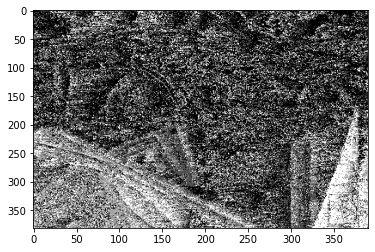

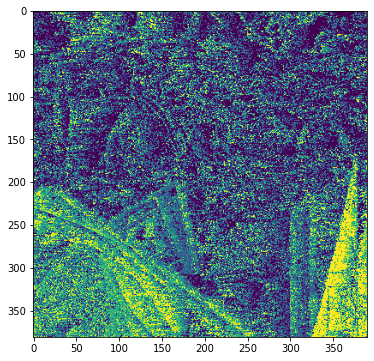

In [13]:
# Plotting the depth map in gray scale
depth_map1 = depth_map.reshape(D.shape)
plt.imshow(depth_map1, cmap="gray", aspect = 'auto')

# Plotting the depth map in RGB scale
plt.figure(figsize=(6,6))
plt.imshow(depth_map1)

## ICM implementation

In [14]:
# Function to calculate the 8 neighbors for a pixel

def neighourhood(i,j):
  neighbours = []
  for a in [-1,0,1]:
    for b in [-1,0,1]:
      neighbours.append((i+a, j+b))
  boundary = []
  for n in neighbours:
      if 0 <= n[0] < 381 and  0 <=n [1] <390:
          boundary.append(n)
  return boundary

In [15]:
# Function to calculate prior 

def priorCalc(c1, c2, a=10 , sigma = 1):
    if c1 == c2:
        return 1
    else:
        return np.exp(-(a/sigma)**2)

In [16]:
# Initialising matrix for image
centers = np.unique(cluster_map)
cluster_map1 = cluster_map.reshape(D.shape)
D_new = np.ones((cluster_map1.shape[0], cluster_map1.shape[1]))

In [17]:
# ICM implementation

for k in range(4):
    # Iterating through all the pixels
    for i in range(cluster_map1.shape[0]):  
        for j in range(cluster_map1.shape[1]):
            neighours = neighourhood(i,j)
            post_class = []

            for c in centers:
                p = gaussianPDF(D[i,j], mean_updated[:,int(c)], cov_updated[:,int(c)])
                # Calculating prior of each neighbor and multiplying it
                prior = 1
                for n in neighours:
                    prior = prior*priorCalc(c, cluster_map1[n])
                # posterior probablity of each centre    
                post_class.append(p*prior)      
            post_class = np.array(post_class)
            
            # selecting the center which has maximum posterity
            cluster_map1[i, j] = np.argmax(post_class)
            D_new[i, j] = mean_updated[:,np.argmax(post_class)]

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

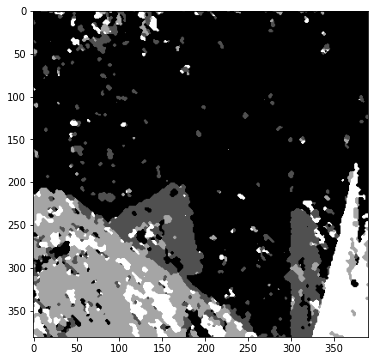

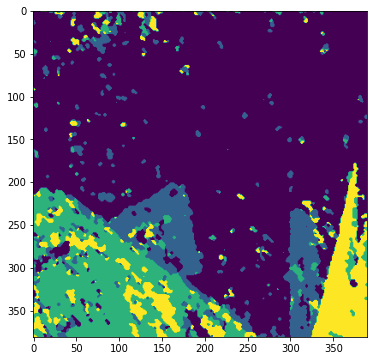

In [18]:
# Plotting the depth map in gray scale
plt.figure(figsize=(6,6))
plt.imshow(D_new, cmap="gray", aspect = 'auto')

# Plotting the depth map in RGB scale
plt.figure(figsize=(6,6))
plt.imshow(D_new)

# P2: Probabilistic Latent Semantic Indexing (PLSI) for Speech Denoising

Sample rate : 16000
Data shape : (456707,)


Shape of STFT of trs data : (513, 893)


<Figure size 432x432 with 0 Axes>

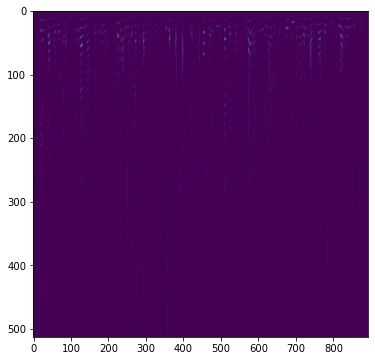

In [5]:
# Loading trs audio file 
trs, samplerate1 = lb.load('trs.wav', sr = None)
print("Sample rate :",samplerate1)
print("Data shape :",trs.shape)
ipd.Audio('trs.wav')

# Applying STFT with 1024 point frames on trs audio and plotting it
trs_stft = lb.stft(trs, n_fft = 1024, hop_length = 512, window='hann',center=True)
print("Shape of STFT of trs data :",trs_stft.shape)
S = abs(trs_stft)
plt.figure(figsize=(6,6))
plt.imshow(S,aspect="auto")
plt.show()

Sample rate : 16000
Data shape : (456707,)


Shape of STFT of trn data : (513, 893)
STFT of piano data : [[-3.5574376e-03+0.0000000e+00j -6.7908750e-03+0.0000000e+00j
  -9.8517053e-03+0.0000000e+00j ... -6.3816309e-03+0.0000000e+00j
  -7.1201809e-03+0.0000000e+00j -1.6732685e-02+0.0000000e+00j]
 [ 1.1026846e-03+1.2159444e-03j  2.0455909e-03+1.6890047e-03j
   5.9694136e-03-6.4847502e-04j ...  2.1708859e-03-1.7024247e-03j
   3.4542666e-03-3.4335145e-04j  1.4713102e-02+1.8777598e-02j]
 [ 3.7634990e-04-8.6216992e-03j -3.3344026e-04+1.2199710e-03j
   5.1318342e-03+3.0973624e-03j ... -2.3553385e-03-9.6402352e-04j
  -2.0351221e-03+2.5188418e-03j -1.1379815e-02-3.5805140e-02j]
 ...
 [-1.7810195e-03-1.4093773e-04j  7.6388679e-02+7.8313917e-02j
   1.7521068e-01+1.2231477e-01j ... -9.0829225e-04+4.4174938e-04j
  -2.5522972e-02-1.5981989e-02j -4.3544006e-02-1.6663007e-02j]
 [ 1.2435983e-03-9.6943002e-04j -4.6995737e-02+7.9081438e-02j
   4.4871829e-02-1.7542005e-01j ... -6.4021052e-04+8.3893619e-04j
   8.0417125e-03-2.7185449e-02j -1.1301175e

<Figure size 432x432 with 0 Axes>

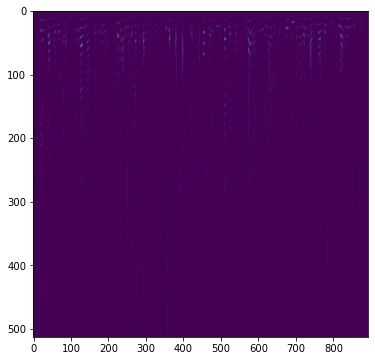

In [6]:
# Loading trn audio file 
trn, samplerate2 = lb.load('trn.wav', sr = None)
print("Sample rate :",samplerate2)
print("Data shape :",trn.shape)
ipd.Audio('trn.wav')

# Applying STFT with 1024 point frames on trn audio and plotting it
trn_stft = lb.stft(trn, n_fft = 1024, hop_length = 512, window='hann',center=True)
print("Shape of STFT of trn data :",trn_stft.shape)
print("STFT of piano data :", trn_stft)
N = abs(trn_stft)
plt.figure(figsize=(6,6))
plt.imshow(S,aspect="auto")
plt.show()

Sample rate : 16000
Data shape : (81920,)


Shape of STFT of tex data : (513, 161)


<Figure size 432x432 with 0 Axes>

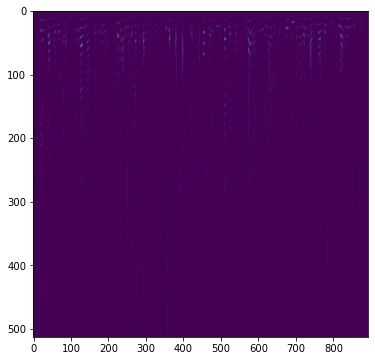

In [7]:
# Loading tex audio file 
tex, samplerate3 = lb.load('tex.wav', sr = None)
print("Sample rate :",samplerate3)
print("Data shape :",tex.shape)
ipd.Audio('tex.wav')

# Applying STFT with 1024 point frames on tex audio and plotting it
tex_stft = lb.stft(tex, n_fft = 1024, hop_length = 512, window='hann', center=True)
print("Shape of STFT of tex data :",tex_stft.shape)
X = abs(tex_stft)
plt.figure(figsize=(6,6))
plt.imshow(S,aspect="auto")
plt.show()

Sample rate : 16000
Data shape : (81920,)


Shape of STFT of piano data : (513, 161)


<Figure size 432x432 with 0 Axes>

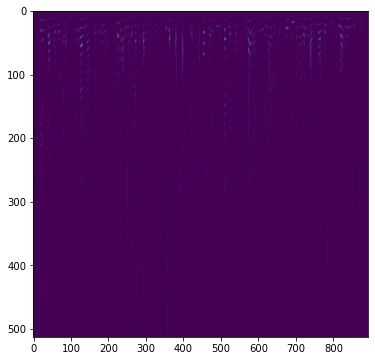

In [8]:
# Loading tex audio file 
tes, samplerate4 = lb.load('tes.wav', sr = None)
print("Sample rate :",samplerate4)
print("Data shape :",tes.shape)
ipd.Audio('tes.wav')

# Applying STFT with 1024 point frames on tes audio and plotting it
tes_stft = lb.stft(tes, n_fft = 1024, hop_length = 512, window='hann',center=True)
print("Shape of STFT of piano data :",tes_stft.shape)
Y = abs(tes_stft)
plt.figure(figsize=(6,6))
plt.imshow(S,aspect="auto")
plt.show()

## PLSI Implementation

In [9]:
def updateWt(A,Ks):
  # Initialising PLSI topics B
  B = np.random.randn(A.shape[0], Ks)
  # Initialising the weights W
  W = np.random.randn(Ks, A.shape[1])

  one_arr1 = np.ones([B.shape[0], B.shape[0]])
  one_arr2 = np.ones([W.shape[0], W.shape[0]])

  # Updating the topics and weights 
  for i in range(500):
    # Updating topics 
    denom1 = np.dot(B,W) +  0.00000001
    B = B * np.dot((A/denom1), W.T)

    # Updating weights
    denom2 = np.dot(B,W) +  0.00000001
    W = W * np.dot(B.T, (A/denom2))

    B = B / (np.dot(one_arr1, B) +  0.00000001)
    W = W / (np.dot(one_arr2, W) +  0.00000001)

  return B, W

In [10]:
def UpdateTheta(A,K,B):
  W = np.random.rand(K,A.shape[1])
  one_arr = np.ones([W.shape[0], W.shape[0]])

  # Updating the weights 
  for i in range(500):
    # Updating weights
    denom = np.dot(B,W) +  0.00000001
    W = W * np.dot(B.T, (A/denom))
    W = W / (np.dot(one_arr, W)  +  0.00000001)
  
  return W

In [11]:
Ks = 30
B1, W1 = updateWt(S,Ks)
B1

array([[-0., -0.,  0., ..., -0., -0., -0.],
       [ 0., -0.,  0., ...,  0.,  0.,  0.],
       [-0., -0., -0., ...,  0.,  0., -0.],
       ...,
       [-0., -0.,  0., ...,  0., -0.,  0.],
       [ 0., -0., -0., ...,  0.,  0., -0.],
       [ 0., -0.,  0., ..., -0., -0., -0.]])

In [12]:
B2, W2 = updateWt(N,Ks)
B2

array([[-0.        ,  0.00022481, -0.        , ..., -0.        ,
         0.        , -0.        ],
       [ 0.        ,  0.00012935, -0.        , ..., -0.        ,
        -0.        ,  0.        ],
       [ 0.        ,  0.00020132, -0.        , ..., -0.        ,
         0.        ,  0.        ],
       ...,
       [-0.        ,  0.0016982 ,  0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        ,  0.00168791, -0.        , ..., -0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.0016077 ,  0.        , ...,  0.        ,
         0.        , -0.        ]])

In [13]:
B3 = np.hstack((B1,B2))
B3.shape

(513, 60)

In [14]:
K = 60
W3 = UpdateTheta(X,K,B3)
W3

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
# Computing probability matrix
probability_mat = np.dot(B1,W3[:30,:])

# Computing S hat test
denom = np.dot(B3,W3) + 0.0000000001
S_te1 = probability_mat/denom
S_te = np.multiply(S_te1,tes_stft)

In [16]:
#Transforming an stft matrix into an original sound wave using Hann window

S_recovered = lb.istft(S_te, hop_length = 512,center=True)
ipd.Audio(S_recovered.real, rate=samplerate1)

In [17]:
# Function to calculate signal to noise ratio

def SNRCalc(true, pred):
    return 10*np.log10((true.T @ pred)/((true-pred).T @ (true-pred)))

In [18]:
SNR = SNRCalc(tes, S_recovered)
print("Signal to noise ratio of the recovered speech :", round(SNR,2))

Signal to noise ratio of the recovered speech : 9.2


# P3: PLSI for Analyzing Twitter Stream

In [19]:
# Loading the twitter data file

twitter = scipy.io.loadmat('twitter.mat')
X_tr = twitter['Xtr']
X_te = twitter['Xte']
Y_trMat = twitter['YtrMat']
Y_teMat = twitter['YteMat']

In [20]:
len(X_tr)

891

In [21]:
len(X_tr[0])

773

In [72]:
# Updating B and W using PLSI update rules

Ks = 50
B1, W1 = updateWt(X_tr,Ks)
B1

array([[-0.        ,  0.        , -0.        , ..., -0.        ,
         0.        ,  0.        ],
       [-0.        , -0.        , -0.        , ...,  0.        ,
        -0.        ,  0.        ],
       [-0.        , -0.        ,  0.        , ..., -0.        ,
         0.02224895, -0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.        ,  0.        ],
       [ 0.        , -0.        , -0.        , ..., -0.        ,
         0.        , -0.        ]])

In [73]:
# Updatings weights for test dataset

W2 = np.random.rand(50,193)

for i in range(1000):
    # Updating weights 
    denom = np.dot(B1, W2) + 0.0000000001
    W2 = W2 * np.dot(B1.T, (X_te/denom))
    one_arr = np.ones([W2.shape[0], W2.shape[0]])
    W2 = W2 / np.dot(one_arr, W2)
W2

array([[0.        , 0.        , 0.        , ..., 0.        , 0.01281413,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.06325003,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### Perceptron implementation

In [74]:
# Initialization of weights

Wts = np.random.normal(0, 5, size=(3, W1.shape[0]))
alpha = 0.001
bias = np.random.uniform(0, 5, (3,1))
total_error = []

In [75]:
# Perceptron implementation for softmax

for i in range(10000):
  # Forward Propogation
  forward = np.exp(np.dot(Wts, W1) + bias)
  forward = forward / np.sum(forward, axis=0).reshape(1,-1)
  error = - np.sum(Y_trMat * np.log(forward))
  total_error.append(error)

  # Backward Propogation
  Wts_delta = np.dot((forward - Y_trMat), W1.T)
  bias_delta = np.dot((forward - Y_trMat), np.ones([Y_trMat.shape[1],1]))

  # Updating the weights and bias
  Wts = Wts - (alpha * Wts_delta)
  bias = bias - (alpha * bias_delta)

In [76]:
# Updating weights for test data

Z = np.dot(Wts, W2) + bias
forward_test = np.exp(Z)
forward_test = forward_test / np.sum(forward_test, axis=0).reshape(1,-1)

In [77]:
# Calculating train and test accuracy

tr_acc = np.sum(np.argmax(forward, axis=0) == np.argmax(Y_trMat, axis=0)) / Y_trMat.shape[1]
print("Train accuacy is: " + str((np.round(tr_acc, 1))*100) + "%")

te_acc = np.sum(np.argmax(forward_test, axis=0) == np.argmax(Y_teMat, axis=0)) / Y_teMat.shape[1]
print("Test accuacy is: " + str((np.round(te_acc, 1))*100) + "%")

Train accuacy is: 60.0%
Test accuacy is: 50.0%


<Figure size 864x576 with 0 Axes>

Text(0.5, 0, 'Number of Epochs')

Text(0, 0.5, 'Total Error')

Text(0.5, 1.0, 'Convergence for Perceptron')

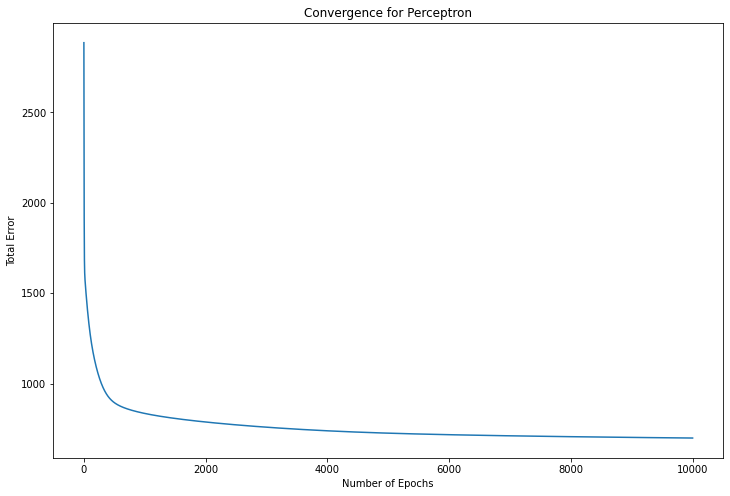

In [78]:
# Plotting error for different iterations 

plt.figure(figsize=[12,8]);
plt.plot(total_error)
plt.xlabel('Number of Epochs');
plt.ylabel('Total Error');
plt.title('Convergence for Perceptron');
plt.show()